# Contrastive Learning with MNIST Using Pytorch

In [22]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from tqdm import tqdm

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR

## GPU Setup (Optional)

In [2]:
torch.__version__
# '1.13.0+cu117'

'1.13.0+cu117'

In [3]:
# Get info of all GPU devices
!nvidia-smi

Wed Jul  5 16:03:24 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:22:00.0 Off |                  N/A |
|  0%   42C    P8              14W / 170W |      0MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# Set environment variable with possible device ids
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
print(os.environ["CUDA_VISIBLE_DEVICES"])
# Set device: 0 or 1
# NOTE: indices are not necessarily the ones shown by nvidia-smi
# We need to try them with the cell below
torch.cuda.set_device("cuda:0")

0,1


In [5]:
# Check that the selected device is the desired one
print("Torch version?", torch.__version__)
print("Torchvision version?", torchvision.__version__)
print("Is cuda available?", torch.cuda.is_available())
print("Is cuDNN version:", torch.backends.cudnn.version())
print("cuDNN enabled? ", torch.backends.cudnn.enabled)
print("Device count?", torch.cuda.device_count())
print("Current device?", torch.cuda.current_device())
print("Device name? ", torch.cuda.get_device_name(torch.cuda.current_device()))
x = torch.rand(5, 3)
print(x)

Torch version? 1.13.0+cu117
Torchvision version? 0.14.0+cu117
Is cuda available? True
Is cuDNN version: 8500
cuDNN enabled?  True
Device count? 1
Current device? 0
Device name?  NVIDIA GeForce RTX 3060
tensor([[0.6551, 0.6354, 0.3360],
        [0.9716, 0.3431, 0.2295],
        [0.0047, 0.9451, 0.6091],
        [0.7306, 0.5835, 0.1021],
        [0.2828, 0.6482, 0.2419]])


## Config and Dataset

In [6]:
# Configuration class
class Config:
    def __init__(self):
        # Hyperparameters
        self.learning_rate = 0.001
        self.num_epochs = 10
        self.batch_size = 64
        self.patience = 5  # For early stopping
        self.dropout_p = 0.5
        self.embedding_size = 128  # Size of the embedding/feature vectors
        self.scheduler_step_size = 10  # Step size for the learning rate scheduler
        self.scheduler_gamma = 0.1  # Gamma for the learning rate scheduler: every step_size lr is multiplied by gamma
        self.img_shape = (28, 28)  # Not used in this application
        # Other application variables
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.base_path = "./output"
        os.makedirs(self.base_path, exist_ok=True)  # Create the base_path directory if it doesn't exist
        self.model_path = os.path.join(self.base_path, "best_model.pth")
        self.learning_plot_path = os.path.join(self.base_path, "learning_curves.png")
        self.threshold_plot_path = os.path.join(self.base_path, "threshold_histogram.png")

In [7]:
# Dataset generator class
class PairDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.transform = transforms.ToTensor()

    def __getitem__(self, index):
        img1, label1 = self.mnist_dataset[index]
        index2 = torch.randint(len(self.mnist_dataset), size=(1,)).item()
        img2, label2 = self.mnist_dataset[index2]
        return img1, img2, torch.tensor(int(label1 == label2), dtype=torch.float32)

    def __len__(self):
        return len(self.mnist_dataset)

## Definitions: Siamese Network, Train, Predict

In [15]:
# Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size=128, dropout_p=0.3):
        super(SiameseNetwork, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.embedding_size = embedding_size
        self.dropout_p = dropout_p

        # Remove the fully connected layer
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])

        for param in self.backbone.parameters():
            param.requires_grad = False

        self.head = nn.Sequential(
            #nn.Linear(self.backbone[-1].out_features, 512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(self.dropout_p),
            nn.Linear(256, self.embedding_size)
        )

    def forward_one(self, x):
        x = self.backbone(x)
        x = x.view(x.size()[0], -1)
        x = self.head(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

# Contrastive loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # pairwise_distance(): equivalent to euclidean_distance:
        # torch.sqrt(((output1 - output2) ** 2).sum(dim=1))
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

# Save model function
def save_model(model, save_path):
    torch.save(model.state_dict(), save_path)

# Load model function
def load_model(model, load_path, device):
    model.load_state_dict(torch.load(load_path, map_location=device))
    return model
        
# Training function
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, config):
    model.train()
    train_loss_history = []
    val_loss_history = []
    best_val_loss = float('inf')
    no_improve_epochs = 0
    for epoch in range(config.num_epochs):
        start_time = time.time()
        train_loss = 0
        for i, (img1, img2, labels) in enumerate(train_loader):
            img1, img2, labels = img1.to(config.device), img2.to(config.device), labels.to(config.device)
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Print training loss every 100 batches
            if i % 100 == 0:
                print(f"Epoch: {epoch+1}, Batch: {i+1}, Loss: {loss.item()}")

        scheduler.step()
        train_loss_history.append(train_loss / len(train_loader))

        val_loss = validate(model, val_loader, criterion, config)
        val_loss_history.append(val_loss)
        end_time = time.time()
        epoch_time = end_time - start_time

        print(f"Epoch: {epoch+1}, Loss: {train_loss_history[-1]}, Val Loss: {val_loss}, Time: {epoch_time}s, Learning Rate: {scheduler.get_last_lr()[0]}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(model, config.model_path)
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= config.patience:
                print("Early stopping")
                break

    return train_loss_history, val_loss_history


# Validation function
def validate(model, val_loader, criterion, config):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, (img1, img2, labels) in enumerate(val_loader):
            img1, img2, labels = img1.to(config.device), img2.to(config.device), labels.to(config.device)
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, labels)
            total_loss += loss.item()
    return total_loss / len(val_loader)

In [9]:
# Plot training function
def plot_training(train_loss_history, val_loss_history, config):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(config.learning_plot_path)
    plt.show()
    
# Prediction function
def predict(model, img1, img2):
    model.eval()
    with torch.no_grad():
        output1, output2 = model(img1, img2)
        return euclidean_distance(output1, output2)

# Plot prediction function
def plot_prediction(img1, img2, distances, limit=None):
    if limit is not None:
        img1, img2, distances = img1[:limit], img2[:limit], distances[:limit]

    fig, axs = plt.subplots(len(img1), 2, figsize=(5, len(img1)*5))
    for i in range(len(img1)):
        axs[i, 0].imshow(img1[i].squeeze(), cmap='gray')
        axs[i, 1].imshow(img2[i].squeeze(), cmap='gray')
        axs[i, 1].set_title(f"Distance: {distances[i].item():.2f}")
    plt.show()

In [23]:
# Evaluation
def evaluate(model, test_loader, config):
    model = model.to('cpu')
    model.eval()
    positive_distances = []
    negative_distances = []
    labels_list = []

    with torch.no_grad():
        for img1, img2, labels in tqdm(test_loader, desc="Evaluating", unit="batch"):
            output1, output2 = model(img1, img2)
            distances = F.pairwise_distance(output1, output2).detach().numpy()
            labels = labels.numpy()

            positive_distances.extend(distances[labels == 1])
            negative_distances.extend(distances[labels == 0])
            labels_list.extend(labels)

    # Compute best threshold
    distances = positive_distances + negative_distances
    labels = np.array([1]*len(positive_distances) + [0]*len(negative_distances))
    fpr, tpr, thresholds = roc_curve(labels, distances, pos_label=0)
    best_threshold = thresholds[np.argmax(tpr - fpr)]

    # Compute histograms
    plt.hist(positive_distances, bins=30, alpha=0.5, color='r', label='Positive pairs')
    plt.hist(negative_distances, bins=30, alpha=0.5, color='b', label='Negative pairs')
    
    # Plot best threshold
    plt.axvline(x=best_threshold, color='g', linestyle='--', label=f'Best threshold: {best_threshold:.2f}')
    plt.legend()
    plt.savefig(config.threshold_plot_path)
    plt.show()

    return best_threshold

## Main Application

In [24]:
# Main function
def main(do_train=True):
    config = Config()

    # Define the transformations for the training set
    train_transform = transforms.Compose([
        transforms.Resize((230, 230)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert grayscale to RGB
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(224),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Define the transformations for the validation and test sets
    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert grayscale to RGB
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load MNIST dataset
    mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
    print("Dataset obtained!")

    # Split the dataset into train, validation, and test sets
    train_size = int(0.7 * len(mnist_dataset))
    val_size = int(0.15 * len(mnist_dataset))
    test_size = len(mnist_dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(mnist_dataset, [train_size, val_size, test_size])
    print("Dataset splits created!")

    # Apply the appropriate transformations to the validation and test sets
    val_dataset.dataset.transform = val_test_transform
    test_dataset.dataset.transform = val_test_transform

    # Create PairDataset for each split
    train_dataset = PairDataset(train_dataset)
    val_dataset = PairDataset(val_dataset)
    test_dataset = PairDataset(test_dataset)

    # Create DataLoader for each split
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
    print("Dataset loaders created!")

    # Instantiate the model, criterion, optimizer, and scheduler
    model = SiameseNetwork(embedding_size=config.embedding_size,
                           dropout_p=config.dropout_p).to(config.device)
    criterion = ContrastiveLoss()
    optimizer = Adam(model.parameters(), lr=config.learning_rate)
    scheduler = StepLR(optimizer, step_size=config.scheduler_step_size, gamma=config.scheduler_gamma)
    print("Model instantiated!")
    
    # Train the model
    if do_train:
        print("Starting training...")
        train_loss_history, val_loss_history = train(model, train_loader, val_loader, criterion, optimizer, scheduler, config)
        print("Training completed!")
    
        # Plot training history
        plot_training(train_loss_history, val_loss_history, config)

    # Load the best model
    model = SiameseNetwork(embedding_size=config.embedding_size,
                           dropout_p=config.dropout_p).to(config.device)
    model = load_model(model, config.model_path, config.device)

    # Evaluate
    print("Evaluating model...")
    best_threshold = evaluate(model, test_loader, config)
    print(f"Best threshold: {best_threshold}")
    print("Evaluation completed!")
    
    # Test the model
    test_img1, test_img2, _ = next(iter(test_loader))
    test_img1, test_img2 = test_img1.to(config.device), test_img2.to(config.device)
    distances = predict(model, test_img1, test_img2)

    # Plot predictions
    plot_prediction(test_img1.cpu(), test_img2.cpu(), distances.cpu(), limit=10)

In [25]:
#if __name__ == "__main__":
#    main()

Dataset obtained!
Dataset splits created!
Dataset loaders created!
Model instantiated!
Evaluating model...


Evaluating: 100%|█████████████████████████████████████████████████████████████████| 141/141 [19:33<00:00,  8.32s/batch]


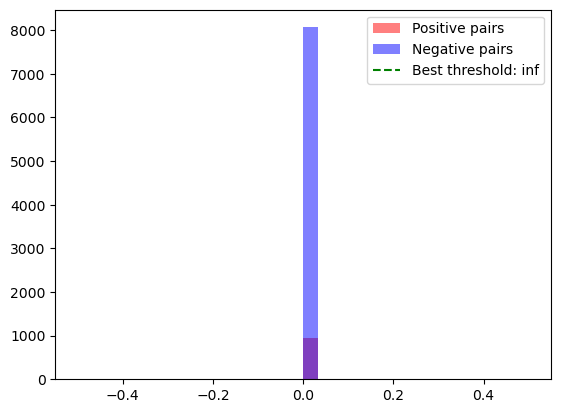

Best threshold: inf
Evaluation completed!


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [26]:
#main(do_train=True)
main(do_train=False)